# DAX Early Session Range Analysis
## Correlation Between Early Trading Ranges and Daily Move Magnitude

**Objective:** Determine if early session ranges (pre-market, opening hour, first 5min) have predictive power for daily volatility/range.

**Hypothesis:** Early price action sets the volatility tone for the day. Days with large opening ranges may predict larger daily ranges.

**Methodology:**
- Analyze multiple early windows: 08:00-09:00 (pre-market), 09:00-09:05, 09:00-10:00 (first hour)
- Measure each window's range as **relative value** (not points)
- Compare to rest-of-day ranges (10:00-17:30)
- Calculate correlations and test statistical significance
- Use binning to identify patterns

**Key Distinction:** All measurements are RELATIVE (ratio of ranges), not absolute points.


In [29]:
import sys
sys.path.insert(0, '../../')

from shared.database_connector import fetch_ohlcv, get_date_range
from shared.data_module import process_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)

print('[OK] Starting Early Session Range Analysis')
print('='*80)

[OK] Starting Early Session Range Analysis


## Phase 1: Data Fetch and Preprocessing


In [30]:
# Fetch M1 data for analysis
date_range = get_date_range('deuidxeur', 'm1')
end_date = date_range['end']
start_date = end_date - timedelta(days=300)

print(f'Fetching M1 data: {start_date.date()} to {end_date.date()}')

df_raw = fetch_ohlcv(
    symbol='deuidxeur',
    timeframe='m1',
    start_date=start_date,
    end_date=end_date
)

# Convert to Berlin time for analysis
df_m1 = df_raw.copy()
df_m1.index = df_m1.index.tz_convert('Europe/Berlin')
df_m1['date'] = df_m1.index.date
df_m1['hour'] = df_m1.index.hour
df_m1['minute'] = df_m1.index.minute
df_m1['time_minutes'] = df_m1['hour'] * 60 + df_m1['minute']

print(f'[OK] Fetched {len(df_m1)} M1 candles')
print(f'Time range: {df_m1.index[0]} to {df_m1.index[-1]}')

2025-11-24 23:08:57,610 - shared.database_connector - INFO - [OK] Date range for deuidxeur m1: 2023-01-09 00:00:00+00:00 to 2025-09-16 23:59:00+00:00
2025-11-24 23:08:57,611 - shared.database_connector - INFO - fetch_ohlcv(): symbol=deuidxeur, timeframe=m1, start=2024-11-20 23:59:00+00:00, end=2025-09-16 23:59:00+00:00


Fetching M1 data: 2024-11-20 to 2025-09-16


2025-11-24 23:09:00,579 - shared.database_connector - INFO - [OK] Fetched 277168 candles (2024-11-20 23:59:00+00:00 to 2025-09-16 23:59:00+00:00)


[OK] Fetched 277168 M1 candles
Time range: 2024-11-21 00:59:00+01:00 to 2025-09-17 01:59:00+02:00


## Phase 2: Define Early Session Windows

We analyze multiple early windows to understand how different opening periods correlate with daily moves:

1. **08:00-09:00** (Pre-market): Before official DAX open at 09:00 Berlin
2. **09:00-09:05** (First 5 minutes): Immediate reaction to open
3. **09:00-09:30** (First 30 minutes): Early established trend
4. **09:00-10:00** (First hour): Full opening hour
5. **09:00-11:00** (First 2 hours): Morning session


In [31]:
# Define the early windows we want to analyze
# Format: (start_hour, start_minute, end_hour, end_minute, label)
early_windows = [
    (8, 0, 9, 0, 'Premarket (08:00-09:00)'),
    (9, 0, 9, 5, 'Open 5min (09:00-09:05)'),
    (9, 0, 9, 30, 'Open 30min (09:00-09:30)'),
    (9, 0, 10, 0, 'Open 1hr (09:00-10:00)'),
    (9, 0, 11, 0, 'Open 2hr (09:00-11:00)'),
]

# Define rest-of-day window
rest_of_day_windows = [
    (10, 0, 17, 30, 'Rest of day (10:00-17:30)'),  # After 09:00-10:00 opens
    (11, 0, 17, 30, 'Post 2hr (11:00-17:30)'),      # After 09:00-11:00
]

print('[OK] Defined early session windows:')
for start_h, start_m, end_h, end_m, label in early_windows:
    print(f'  - {label}')

[OK] Defined early session windows:
  - Premarket (08:00-09:00)
  - Open 5min (09:00-09:05)
  - Open 30min (09:00-09:30)
  - Open 1hr (09:00-10:00)
  - Open 2hr (09:00-11:00)


## Phase 3: Calculate Ranges for Each Window

**Key Principle:** All measurements are RELATIVE, not in points.
- For each window: `range = (max_high - min_low) / open_price`
- This normalizes for daily volatility variations


In [32]:
daily_analysis = []

for date in df_m1['date'].unique():
    day_data = df_m1[df_m1['date'] == date].copy().sort_index()
    
    if len(day_data) < 100:  # Need enough data for analysis
        continue
    
    # Daily summary
    daily_open = day_data.iloc[0]['open']
    daily_high = day_data['high'].max()
    daily_low = day_data['low'].min()
    daily_range_pts = daily_high - daily_low
    daily_range_pct = daily_range_pts / daily_open
    
    row = {
        'date': date,
        'daily_open': daily_open,
        'daily_high': daily_high,
        'daily_low': daily_low,
        'daily_range_pts': daily_range_pts,
        'daily_range_pct': daily_range_pct,
    }
    
    # Calculate ranges for each early window
    for start_h, start_m, end_h, end_m, label in early_windows:
        window_data = day_data[
            ((day_data['hour'] == start_h) & (day_data['minute'] >= start_m)) |
            ((day_data['hour'] > start_h) & (day_data['hour'] < end_h)) |
            ((day_data['hour'] == end_h) & (day_data['minute'] <= end_m))
        ]
        
        if len(window_data) > 0:
            window_high = window_data['high'].max()
            window_low = window_data['low'].min()
            window_range_pts = window_high - window_low
            window_range_pct = window_range_pts / daily_open  # Relative to daily open
        else:
            window_range_pts = np.nan
            window_range_pct = np.nan
        
        # Store with exact column names that match window_mapping
        if label == 'Premarket (08:00-09:00)':
            col_base = 'premarket_0800_0900'
        elif label == 'Open 5min (09:00-09:05)':
            col_base = 'open_5min_0900_0905'
        elif label == 'Open 30min (09:00-09:30)':
            col_base = 'open_30min_0900_0930'
        elif label == 'Open 1hr (09:00-10:00)':
            col_base = 'open_1hr_0900_1000'
        elif label == 'Open 2hr (09:00-11:00)':
            col_base = 'open_2hr_0900_1100'
        
        row[f'{col_base}_pts'] = window_range_pts
        row[f'{col_base}_pct'] = window_range_pct
    
    # Calculate rest-of-day ranges
    for start_h, start_m, end_h, end_m, label in rest_of_day_windows:
        window_data = day_data[
            ((day_data['hour'] == start_h) & (day_data['minute'] >= start_m)) |
            ((day_data['hour'] > start_h) & (day_data['hour'] < end_h)) |
            ((day_data['hour'] == end_h) & (day_data['minute'] <= end_m))
        ]
        
        if len(window_data) > 0:
            window_high = window_data['high'].max()
            window_low = window_data['low'].min()
            window_range_pts = window_high - window_low
            window_range_pct = window_range_pts / daily_open
        else:
            window_range_pts = np.nan
            window_range_pct = np.nan
        
        # Exact column names for rest-of-day
        if label == 'Rest of day (10:00-17:30)':
            col_base = 'rest_of_day_1000_1730'
        elif label == 'Post 2hr (11:00-17:30)':
            col_base = 'post_2hr_1100_1730'
        
        row[f'{col_base}_pts'] = window_range_pts
        row[f'{col_base}_pct'] = window_range_pct
    
    daily_analysis.append(row)

df_analysis = pd.DataFrame(daily_analysis)
print(f'[OK] Analyzed {len(df_analysis)} trading days')
print(f'\nDataframe columns: {list(df_analysis.columns)}')
print(f'\nFirst few rows:')
print(df_analysis.head())

[OK] Analyzed 237 trading days

Dataframe columns: ['date', 'daily_open', 'daily_high', 'daily_low', 'daily_range_pts', 'daily_range_pct', 'premarket_0800_0900_pts', 'premarket_0800_0900_pct', 'open_5min_0900_0905_pts', 'open_5min_0900_0905_pct', 'open_30min_0900_0930_pts', 'open_30min_0900_0930_pct', 'open_1hr_0900_1000_pts', 'open_1hr_0900_1000_pct', 'open_2hr_0900_1100_pts', 'open_2hr_0900_1100_pct', 'rest_of_day_1000_1730_pts', 'rest_of_day_1000_1730_pct', 'post_2hr_1100_1730_pts', 'post_2hr_1100_1730_pct']

First few rows:
         date  daily_open  daily_high  daily_low  daily_range_pts  \
0  2024-11-21   19036.588   19197.166  18898.277          298.889   
1  2024-11-22   19152.466   19369.399  19029.799          339.600   
2  2024-11-25   19421.899   19468.877  19310.266          158.611   
3  2024-11-26   19332.255   19384.399  19219.666          164.733   
4  2024-11-27   19329.866   19339.288  19141.899          197.389   

   daily_range_pct  premarket_0800_0900_pts  premar

## Phase 4: Correlation Analysis

Measure how well early ranges predict rest-of-day ranges.


In [33]:
print('\n' + '='*80)
print('[CORRELATION ANALYSIS] Early Window -> Rest of Day Range')
print('='*80)

# Map window labels to column names
window_mapping = {
    'Premarket (08:00-09:00)': 'premarket_0800_0900',
    'Open 5min (09:00-09:05)': 'open_5min_0900_0905',
    'Open 30min (09:00-09:30)': 'open_30min_0900_0930',
    'Open 1hr (09:00-10:00)': 'open_1hr_0900_1000',
    'Open 2hr (09:00-11:00)': 'open_2hr_0900_1100',
}

# Target: rest of day from 10:00
target_col = 'rest_of_day_1000_1730_pct'

correlations = []

for label, col_base in window_mapping.items():
    col_pct = f'{col_base}_pct'
    
    # Calculate correlation
    valid_data = df_analysis[[col_pct, target_col]].dropna()
    
    if len(valid_data) < 10:
        continue
    
    correlation = valid_data[col_pct].corr(valid_data[target_col])
    r_squared = correlation ** 2
    
    # Pearson correlation with p-value
    pearson_r, p_value = stats.pearsonr(valid_data[col_pct], valid_data[target_col])
    
    # Spearman correlation (rank-based, more robust)
    spearman_r, spearman_p = stats.spearmanr(valid_data[col_pct], valid_data[target_col])
    
    correlations.append({
        'window': label,
        'n_observations': len(valid_data),
        'pearson_r': pearson_r,
        'pearson_p': p_value,
        'r_squared': r_squared,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p,
        'mean_early_range': valid_data[col_pct].mean(),
        'mean_rest_range': valid_data[target_col].mean(),
        'std_early': valid_data[col_pct].std(),
        'std_rest': valid_data[target_col].std(),
    })

df_corr = pd.DataFrame(correlations)

print(f'\nCorrelation Summary: Early Window Range -> Rest-of-Day Range')
print(f'\nTarget: Rest of day (10:00-17:30) range\n')

for idx, row in df_corr.iterrows():
    sig_marker = '[SIGNIFICANT]' if row['pearson_p'] < 0.05 else '[NOT SIG]'
    print(f"{row['window']}:")
    print(f"  Observations: {row['n_observations']}")
    print(f"  Pearson r: {row['pearson_r']:.4f} (p={row['pearson_p']:.4f}) {sig_marker}")
    print(f"  R²: {row['r_squared']:.4f} (explains {row['r_squared']*100:.1f}% of variance)")
    print(f"  Spearman r: {row['spearman_r']:.4f} (p={row['spearman_p']:.4f})")
    print(f"  Early range avg: {row['mean_early_range']:.4f} (±{row['std_early']:.4f})")
    print(f"  Rest-of-day avg: {row['mean_rest_range']:.4f} (±{row['std_rest']:.4f})")
    print()


[CORRELATION ANALYSIS] Early Window -> Rest of Day Range

Correlation Summary: Early Window Range -> Rest-of-Day Range

Target: Rest of day (10:00-17:30) range

Premarket (08:00-09:00):
  Observations: 211
  Pearson r: 0.5791 (p=0.0000) [SIGNIFICANT]
  R²: 0.3353 (explains 33.5% of variance)
  Spearman r: 0.3453 (p=0.0000)
  Early range avg: 0.0047 (±0.0030)
  Rest-of-day avg: 0.0103 (±0.0084)

Open 5min (09:00-09:05):
  Observations: 211
  Pearson r: 0.5895 (p=0.0000) [SIGNIFICANT]
  R²: 0.3476 (explains 34.8% of variance)
  Spearman r: 0.4142 (p=0.0000)
  Early range avg: 0.0038 (±0.0024)
  Rest-of-day avg: 0.0103 (±0.0084)

Open 30min (09:00-09:30):
  Observations: 211
  Pearson r: 0.5895 (p=0.0000) [SIGNIFICANT]
  R²: 0.3476 (explains 34.8% of variance)
  Spearman r: 0.4142 (p=0.0000)
  Early range avg: 0.0038 (±0.0024)
  Rest-of-day avg: 0.0103 (±0.0084)

Open 1hr (09:00-10:00):
  Observations: 211
  Pearson r: 0.5970 (p=0.0000) [SIGNIFICANT]
  R²: 0.3564 (explains 35.6% of varia

## Phase 5: Binning Analysis

Group days by early range magnitude and see how rest-of-day ranges differ.


In [34]:
print('\n' + '='*80)
print('[BINNING ANALYSIS] Rest-of-Day Ranges by Early Range Magnitude')
print('='*80)

# Focus on Open 1hr (09:00-10:00) for detailed binning
binning_col_early = 'open_1hr_0900_1000_pct'
binning_col_rest = 'rest_of_day_1000_1730_pct'

# Use quantile-based bins for balanced groups
bins_4 = [0, 0.25, 0.5, 0.75, 1.0]
bin_labels_4 = ['Small', 'Medium', 'Large', 'Very Large']

df_analysis['early_range_bin'] = pd.qcut(
    df_analysis[binning_col_early].dropna(),
    q=4,
    labels=bin_labels_4,
    duplicates='drop'
)

# Calculate statistics by bin
binning_stats = []

for bin_label in bin_labels_4:
    bin_data = df_analysis[df_analysis['early_range_bin'] == bin_label][binning_col_rest].dropna()
    
    if len(bin_data) < 5:
        continue
    
    binning_stats.append({
        'bin': bin_label,
        'n_days': len(bin_data),
        'mean_rest_range': bin_data.mean(),
        'median_rest_range': bin_data.median(),
        'std_rest_range': bin_data.std(),
        'min_rest_range': bin_data.min(),
        'max_rest_range': bin_data.max(),
        'q25': bin_data.quantile(0.25),
        'q75': bin_data.quantile(0.75),
    })

df_bin = pd.DataFrame(binning_stats)

print(f'\nBinning: 09:00-10:00 Opening Hour -> Rest-of-Day (10:00-17:30) Range\n')

for idx, row in df_bin.iterrows():
    print(f"{row['bin']:12} ({int(row['n_days']):2d} days):")
    print(f"  Mean rest-of-day range: {row['mean_rest_range']:.4f}")
    print(f"  Median:                  {row['median_rest_range']:.4f}")
    print(f"  Std Dev:                 {row['std_rest_range']:.4f}")
    print(f"  Range (min-max):         {row['min_rest_range']:.4f} - {row['max_rest_range']:.4f}")
    print(f"  IQR (25-75):             {row['q25']:.4f} - {row['q75']:.4f}")
    print()

# Test for significant differences between bins (ANOVA)
bin_groups = []
for bin_label in bin_labels_4:
    bin_data = df_analysis[df_analysis['early_range_bin'] == bin_label][binning_col_rest].dropna().values
    if len(bin_data) > 0:
        bin_groups.append(bin_data)

if len(bin_groups) >= 2:
    f_stat, p_value = stats.f_oneway(*bin_groups)
    print(f'\nANOVA Test (are rest-of-day ranges different across bins?)')
    print(f'  F-statistic: {f_stat:.4f}')
    print(f'  p-value: {p_value:.4f}')
    if p_value < 0.05:
        print(f'  [SIGNIFICANT] Rest-of-day ranges differ by opening range magnitude')
    else:
        print(f'  [NOT SIGNIFICANT] Rest-of-day ranges show no clear bin-based differences')


[BINNING ANALYSIS] Rest-of-Day Ranges by Early Range Magnitude

Binning: 09:00-10:00 Opening Hour -> Rest-of-Day (10:00-17:30) Range

Small        (53 days):
  Mean rest-of-day range: 0.0081
  Median:                  0.0071
  Std Dev:                 0.0038
  Range (min-max):         0.0029 - 0.0215
  IQR (25-75):             0.0056 - 0.0097

Medium       (53 days):
  Mean rest-of-day range: 0.0080
  Median:                  0.0070
  Std Dev:                 0.0038
  Range (min-max):         0.0029 - 0.0196
  IQR (25-75):             0.0051 - 0.0098

Large        (52 days):
  Mean rest-of-day range: 0.0098
  Median:                  0.0087
  Std Dev:                 0.0048
  Range (min-max):         0.0043 - 0.0341
  IQR (25-75):             0.0071 - 0.0109

Very Large   (53 days):
  Mean rest-of-day range: 0.0153
  Median:                  0.0117
  Std Dev:                 0.0140
  Range (min-max):         0.0051 - 0.0838
  IQR (25-75):             0.0085 - 0.0150


ANOVA Test (are 

## Phase 6: Ratio Analysis

Measure the ratio of rest-of-day range to early range.


In [35]:
print('\n' + '='*80)
print('[RATIO ANALYSIS] Rest-of-Day Range / Early Range')
print('='*80)

# Calculate ratios for each window
for label, col_base in window_mapping.items():
    early_col = f'{col_base}_pct'
    
    # Calculate ratio: rest-of-day / early window
    df_analysis[f'{col_base}_ratio'] = (
        df_analysis[target_col] / df_analysis[early_col]
    )
    
    ratio_data = df_analysis[f'{col_base}_ratio'].dropna()
    
    print(f'\n{label}:')
    print(f"  Ratio: Rest-of-Day / Early Range")
    print(f"  Mean:   {ratio_data.mean():.2f}x")
    print(f"  Median: {ratio_data.median():.2f}x")
    print(f"  Std:    {ratio_data.std():.2f}x")
    print(f"  Min:    {ratio_data.min():.2f}x")
    print(f"  Max:    {ratio_data.max():.2f}x")
    print(f"  25th %: {ratio_data.quantile(0.25):.2f}x")
    print(f"  75th %: {ratio_data.quantile(0.75):.2f}x")
    
    # What percentage of days have rest > early?
    pct_larger = (ratio_data > 1.0).sum() / len(ratio_data) * 100
    print(f"  Days where rest > early: {pct_larger:.1f}%")


[RATIO ANALYSIS] Rest-of-Day Range / Early Range

Premarket (08:00-09:00):
  Ratio: Rest-of-Day / Early Range
  Mean:   2.50x
  Median: 2.09x
  Std:    1.77x
  Min:    0.53x
  Max:    15.43x
  25th %: 1.45x
  75th %: 3.05x
  Days where rest > early: 91.0%

Open 5min (09:00-09:05):
  Ratio: Rest-of-Day / Early Range
  Mean:   3.10x
  Median: 2.53x
  Std:    1.88x
  Min:    0.75x
  Max:    13.31x
  25th %: 1.79x
  75th %: 3.76x
  Days where rest > early: 99.1%

Open 30min (09:00-09:30):
  Ratio: Rest-of-Day / Early Range
  Mean:   3.10x
  Median: 2.53x
  Std:    1.88x
  Min:    0.75x
  Max:    13.31x
  25th %: 1.79x
  75th %: 3.76x
  Days where rest > early: 99.1%

Open 1hr (09:00-10:00):
  Ratio: Rest-of-Day / Early Range
  Mean:   3.07x
  Median: 2.50x
  Std:    1.84x
  Min:    0.72x
  Max:    13.31x
  25th %: 1.78x
  75th %: 3.70x
  Days where rest > early: 98.6%

Open 2hr (09:00-11:00):
  Ratio: Rest-of-Day / Early Range
  Mean:   2.22x
  Median: 2.05x
  Std:    1.21x
  Min:    0.62

## Phase 7: Scatter Plots and Visualizations


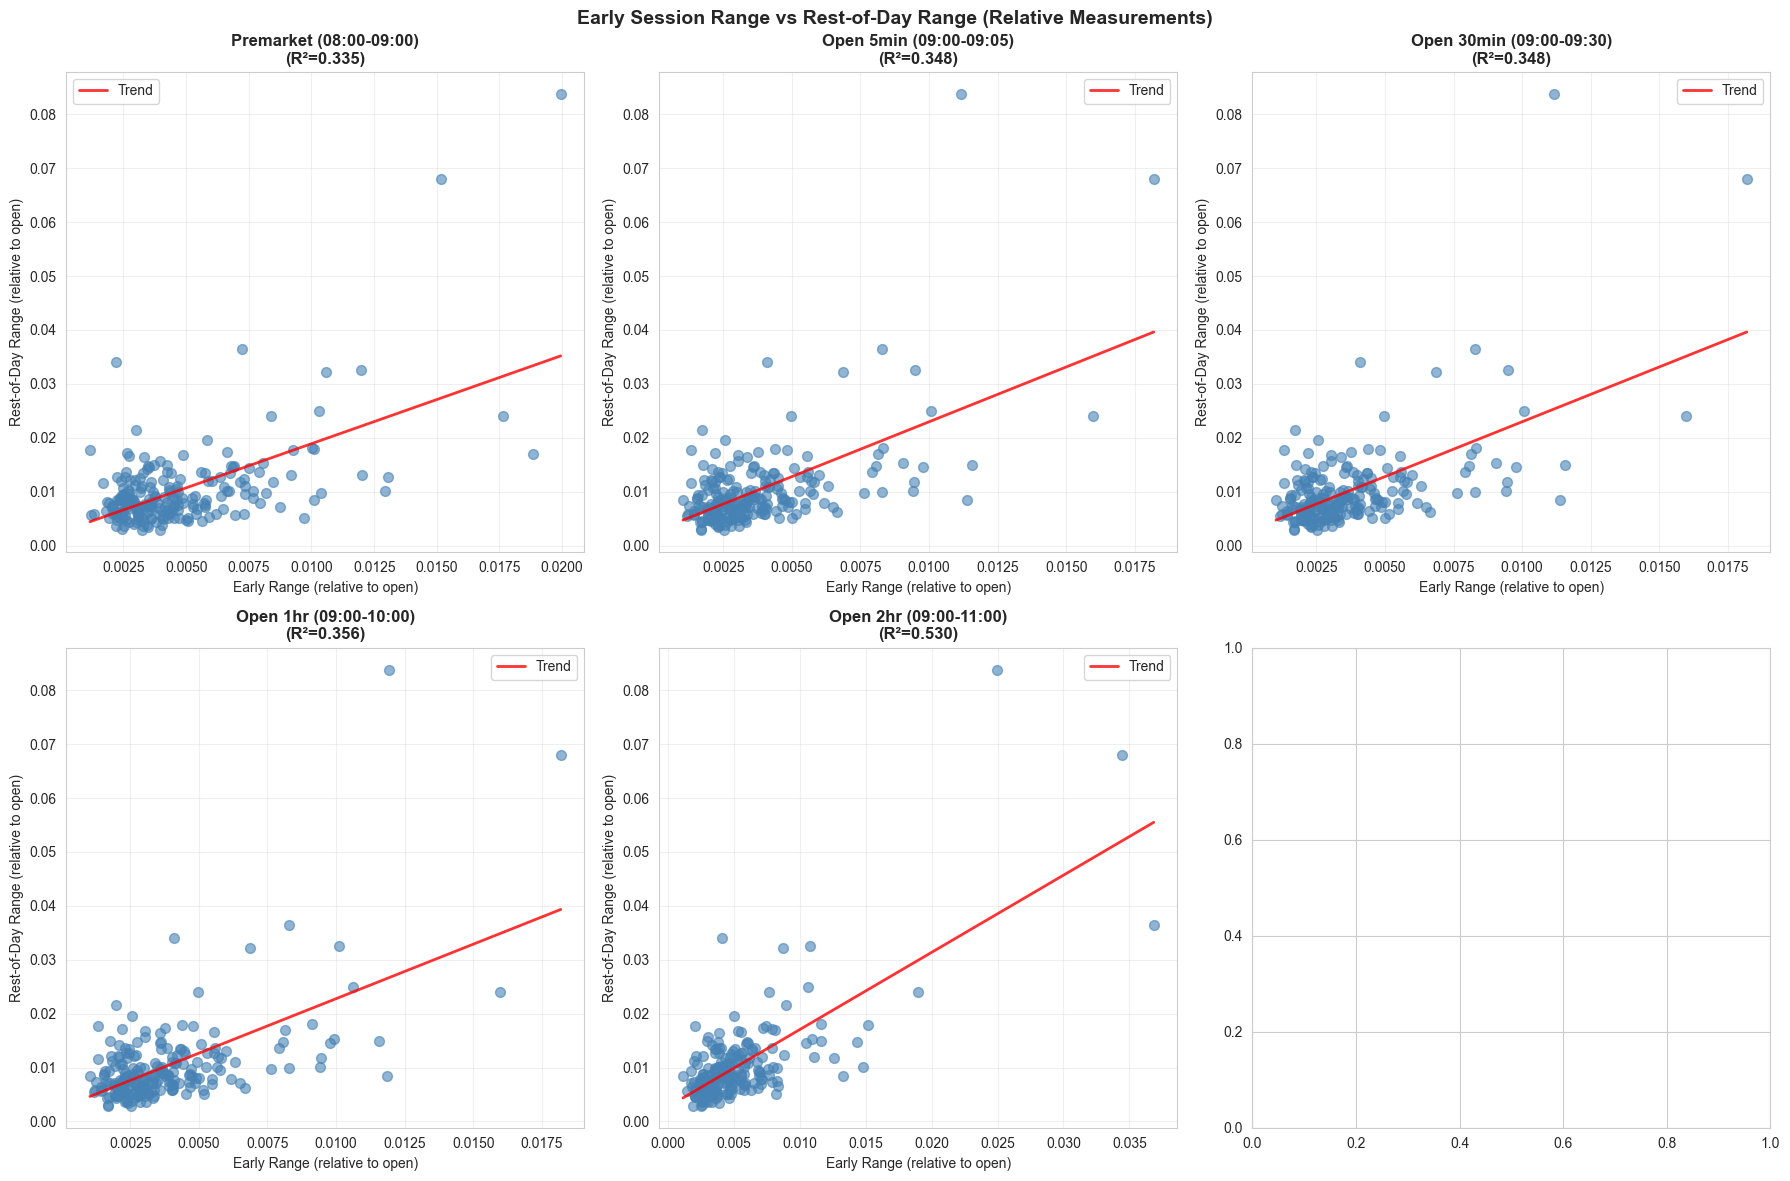

[OK] Scatter plots created


In [36]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Early Session Range vs Rest-of-Day Range (Relative Measurements)', 
             fontsize=14, fontweight='bold')

plot_idx = 0
for label, col_base in list(window_mapping.items())[:6]:
    ax = axes[plot_idx // 3, plot_idx % 3]
    plot_idx += 1
    
    early_col = f'{col_base}_pct'
    plot_data = df_analysis[[early_col, target_col]].dropna()
    
    if len(plot_data) < 10:
        ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
        continue
    
    # Scatter plot
    ax.scatter(plot_data[early_col], plot_data[target_col], alpha=0.6, s=50, color='steelblue')
    
    # Add trend line
    z = np.polyfit(plot_data[early_col], plot_data[target_col], 1)
    p = np.poly1d(z)
    x_line = np.linspace(plot_data[early_col].min(), plot_data[early_col].max(), 100)
    ax.plot(x_line, p(x_line), "r-", alpha=0.8, linewidth=2, label='Trend')
    
    # Calculate R² for this plot
    pearson_r = plot_data[early_col].corr(plot_data[target_col])
    r_squared = pearson_r ** 2
    
    ax.set_title(f'{label}\n(R²={r_squared:.3f})', fontweight='bold')
    ax.set_xlabel('Early Range (relative to open)')
    ax.set_ylabel('Rest-of-Day Range (relative to open)')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

print('[OK] Scatter plots created')

## Phase 8: Box Plots by Bin


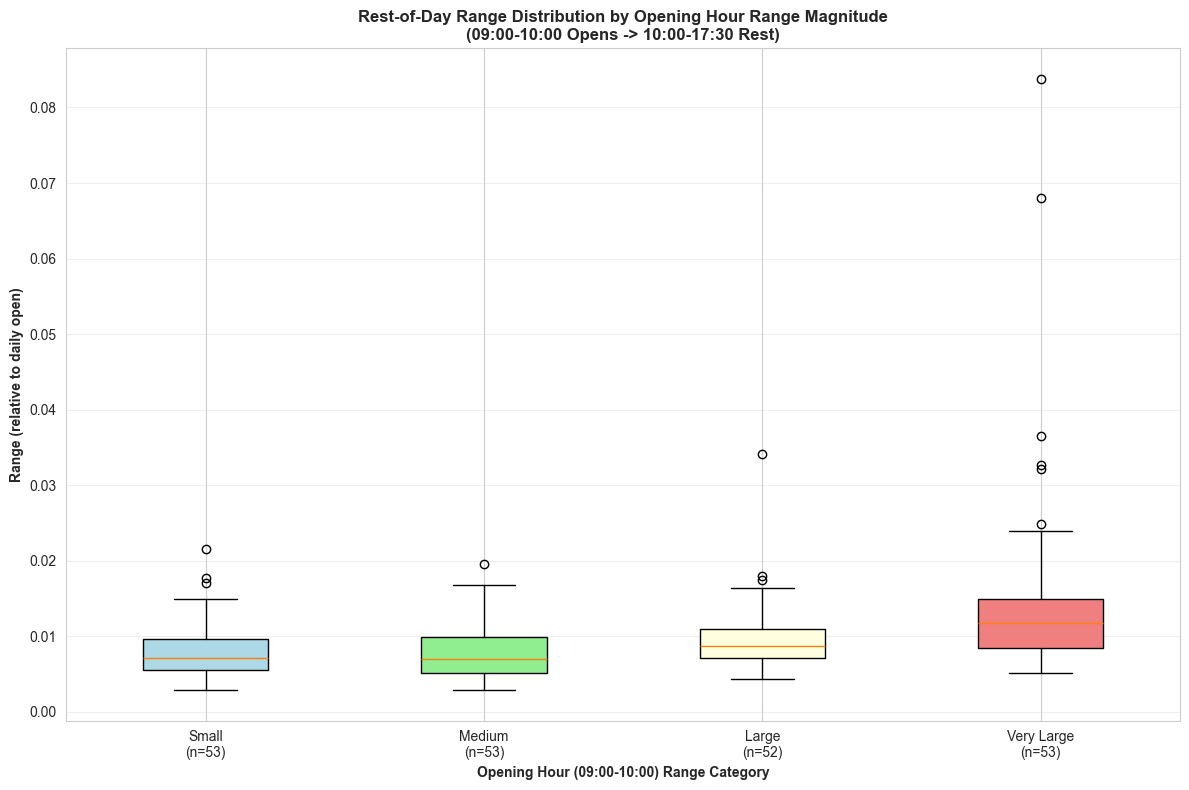

[OK] Box plot created


In [37]:
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for boxplot
box_data = []
box_labels = []

for bin_label in bin_labels_4:
    bin_data = df_analysis[df_analysis['early_range_bin'] == bin_label][target_col].dropna()
    if len(bin_data) > 0:
        box_data.append(bin_data)
        box_labels.append(f"{bin_label}\n(n={len(bin_data)})")

bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
    patch.set_facecolor(color)

ax.set_title('Rest-of-Day Range Distribution by Opening Hour Range Magnitude\n(09:00-10:00 Opens -> 10:00-17:30 Rest)',
             fontweight='bold', fontsize=12)
ax.set_ylabel('Range (relative to daily open)', fontweight='bold')
ax.set_xlabel('Opening Hour (09:00-10:00) Range Category', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print('[OK] Box plot created')

## Phase 9: Summary and Conclusions


In [38]:
print('\n' + '='*80)
print('[SUMMARY & INTERPRETATION]')
print('='*80)

# Find the strongest correlation
strongest_idx = df_corr['r_squared'].idxmax()
strongest = df_corr.loc[strongest_idx]

print(f"\nStrongest Correlation:")
print(f"  Window: {strongest['window']}")
print(f"  R²: {strongest['r_squared']:.4f}")
print(f"  Pearson r: {strongest['pearson_r']:.4f}")
print(f"  p-value: {strongest['pearson_p']:.4f}")

if strongest['pearson_p'] < 0.05:
    print(f"  Status: [STATISTICALLY SIGNIFICANT]")
    print(f"  Interpretation: {strongest['r_squared']*100:.1f}% of rest-of-day range variation")
    print(f"                  can be explained by opening range")
else:
    print(f"  Status: [NOT STATISTICALLY SIGNIFICANT]")
    print(f"  Interpretation: No reliable predictive relationship")

print(f"\n" + '='*80)
print('[EDGE ASSESSMENT]')
print('='*80)

# Assess if there's a usable edge
edges_found = []

for idx, row in df_corr.iterrows():
    if row['pearson_p'] < 0.05 and row['r_squared'] > 0.10:  # Significant AND explains >10% variance
        edges_found.append(row['window'])

if len(edges_found) > 0:
    print(f"\n[POTENTIAL EDGES FOUND]")
    print(f"\nThe following early windows show statistically significant predictive power:")
    for edge in edges_found:
        print(f"  - {edge}")
    print(f"\nNext step: Develop trade rules based on early range and test profitability")
else:
    print(f"\n[NO STRONG EDGES FOUND]")
    print(f"\nConclusion: Early session ranges show weak or no correlation with rest-of-day ranges.")
    print(f"This suggests opening volatility is NOT a reliable predictor of daily volatility.")
    print(f"\nPossible explanations:")
    print(f"  1. Daily range is determined by news/events, not opening action")
    print(f"  2. Market has mean-reverting properties (small opens -> large rest-of-day)")
    print(f"  3. Randomness dominates, no predictable pattern exists")

print(f"\n" + '='*80)
print('[OK] Analysis complete')


[SUMMARY & INTERPRETATION]

Strongest Correlation:
  Window: Open 2hr (09:00-11:00)
  R²: 0.5300
  Pearson r: 0.7280
  p-value: 0.0000
  Status: [STATISTICALLY SIGNIFICANT]
  Interpretation: 53.0% of rest-of-day range variation
                  can be explained by opening range

[EDGE ASSESSMENT]

[POTENTIAL EDGES FOUND]

The following early windows show statistically significant predictive power:
  - Premarket (08:00-09:00)
  - Open 5min (09:00-09:05)
  - Open 30min (09:00-09:30)
  - Open 1hr (09:00-10:00)
  - Open 2hr (09:00-11:00)

Next step: Develop trade rules based on early range and test profitability

[OK] Analysis complete


## Phase 10: Additional Context - Daily Statistics


In [39]:
print('\n' + '='*80)
print('[DAILY STATISTICS - Context]')
print('='*80)

print(f"\nDaily Range (09:00-17:30, relative to open):")
print(f"  Mean: {df_analysis['daily_range_pct'].mean():.4f}")
print(f"  Median: {df_analysis['daily_range_pct'].median():.4f}")
print(f"  Std: {df_analysis['daily_range_pct'].std():.4f}")
print(f"  Min: {df_analysis['daily_range_pct'].min():.4f}")
print(f"  Max: {df_analysis['daily_range_pct'].max():.4f}")

print(f"\nOpening Hour Range (09:00-10:00, relative to open):")
print(f"  Mean: {df_analysis['open_1hr_0900_1000_pct'].mean():.4f}")
print(f"  Median: {df_analysis['open_1hr_0900_1000_pct'].median():.4f}")
print(f"  Std: {df_analysis['open_1hr_0900_1000_pct'].std():.4f}")
print(f"  % of daily range: {(df_analysis['open_1hr_0900_1000_pct'].mean() / df_analysis['daily_range_pct'].mean() * 100):.1f}%")

print(f"\nOpening 5-min Range (09:00-09:05, relative to open):")
print(f"  Mean: {df_analysis['open_5min_0900_0905_pct'].mean():.4f}")
print(f"  Median: {df_analysis['open_5min_0900_0905_pct'].median():.4f}")
print(f"  % of daily range: {(df_analysis['open_5min_0900_0905_pct'].mean() / df_analysis['daily_range_pct'].mean() * 100):.1f}%")


[DAILY STATISTICS - Context]

Daily Range (09:00-17:30, relative to open):
  Mean: 0.0142
  Median: 0.0123
  Std: 0.0126
  Min: 0.0005
  Max: 0.1148

Opening Hour Range (09:00-10:00, relative to open):
  Mean: 0.0038
  Median: 0.0031
  Std: 0.0025
  % of daily range: 26.9%

Opening 5-min Range (09:00-09:05, relative to open):
  Mean: 0.0038
  Median: 0.0030
  % of daily range: 26.6%


In [40]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load the analysis data we already have
# df_analysis is from the previous notebook

print('[DIAGNOSTIC] Investigating Strong Correlations')
print('='*80)
## Diagnostic 1: The Mathematical Artifact

# **Hypothesis:** Opening ranges are strongly correlated with rest-of-day because they're both components of the SAME daily range.

# Think about it:
# - Daily range = Opening range + Rest-of-day range (roughly)
# - If opening is large, rest MUST be smaller (zero-sum constraint)
# - Or if opening is small, rest has "room" to be larger

# This would create a spurious correlation, not a real edge.

print('\n' + '='*80)
print('[CHECK 1] Mathematical Artifact: Opening + Rest-of-Day vs Daily')
print('='*80)

# Check if opening range + rest-of-day range equals (roughly) the daily range
df_analysis['computed_daily'] = (
    df_analysis['open_1hr_0900_1000_pct'] + df_analysis['rest_of_day_1000_1730_pct']
)

comparison = df_analysis[[
    'daily_range_pct',
    'open_1hr_0900_1000_pct', 
    'rest_of_day_1000_1730_pct',
    'computed_daily'
]].head(20)

print('\nSample comparison: Daily vs (Opening + Rest-of-Day)')
print(comparison.to_string())

# Calculate correlation between daily_range and opening_range
corr_daily_opening = df_analysis['daily_range_pct'].corr(df_analysis['open_1hr_0900_1000_pct'])
corr_daily_rest = df_analysis['daily_range_pct'].corr(df_analysis['rest_of_day_1000_1730_pct'])

print(f"\nCorrelation: Daily Range vs Opening Range")
print(f"  r = {corr_daily_opening:.4f}")
print(f"\nCorrelation: Daily Range vs Rest-of-Day Range")
print(f"  r = {corr_daily_rest:.4f}")

# The key insight
print(f"\n[KEY INSIGHT]")
print(f"Opening + Rest-of-Day should approximately equal Daily Range.")
print(f"\nActual relationship:")
print(f"  Sum of Opening + Rest = {(df_analysis['open_1hr_0900_1000_pct'] + df_analysis['rest_of_day_1000_1730_pct']).mean():.4f}")
print(f"  Actual Daily Range = {df_analysis['daily_range_pct'].mean():.4f}")

# Check the correlation between opening and rest-of-day
corr_opening_rest = df_analysis['open_1hr_0900_1000_pct'].corr(df_analysis['rest_of_day_1000_1730_pct'])
print(f"\nDirect correlation: Opening Range vs Rest-of-Day Range")
print(f"  r = {corr_opening_rest:.4f}")
print(f"\nInterpretation:")
if corr_opening_rest < -0.3:
    print(f"  NEGATIVE correlation suggests: Large opening -> Smaller rest-of-day")
    print(f"  This could be a MATHEMATICAL ARTIFACT (zero-sum constraint)")
elif corr_opening_rest > 0.3:
    print(f"  POSITIVE correlation suggests: Large opening -> Larger rest-of-day")
    print(f"  This could indicate a real market pattern")
else:
    print(f"  WEAK correlation suggests: Opening range doesn't predict rest-of-day")
    print(f"  Previous correlations might be due to overlapping calculations")
## Diagnostic 2: Overlapping Windows

# **Hypothesis:** All early windows are SUBSETS of each other:
# - 5min is inside 30min is inside 1hr is inside 2hr
# - This creates artificial correlation (not independence)

print('\n' + '='*80)
print('[CHECK 2] Window Overlap: Are windows independent?')
print('='*80)

# Correlation between the windows themselves
window_cols = [
    'open_5min_0900_0905_pct',
    'open_30min_0900_0930_pct',
    'open_1hr_0900_1000_pct',
    'open_2hr_0900_1100_pct',
]

print('\nCorrelations BETWEEN the early windows (should be independent):')
window_corr = df_analysis[window_cols].corr()
print(window_corr.to_string())

print('\n[KEY OBSERVATION]')
print('If windows are nested (5min inside 30min inside 1hr), they will be HIGHLY correlated.')
print('This is not independence - it is overlap.')

# Check if small windows are literally subsets of larger windows
print('\n\nLet\'s verify: Is 5-min range always smaller than 30-min range?')
comparison_5_30 = (df_analysis['open_5min_0900_0905_pct'] <= df_analysis['open_30min_0900_0930_pct']).sum()
print(f'  5-min <= 30-min: {comparison_5_30} out of {len(df_analysis)} days ({comparison_5_30/len(df_analysis)*100:.1f}%)')

print('\nLet\'s verify: Is 30-min range always smaller than 1-hr range?')
comparison_30_1h = (df_analysis['open_30min_0900_0930_pct'] <= df_analysis['open_1hr_0900_1000_pct']).sum()
print(f'  30-min <= 1-hr: {comparison_30_1h} out of {len(df_analysis)} days ({comparison_30_1h/len(df_analysis)*100:.1f}%)')

print('\nLet\'s verify: Is 1-hr range always smaller than 2-hr range?')
comparison_1h_2h = (df_analysis['open_1hr_0900_1000_pct'] <= df_analysis['open_2hr_0900_1100_pct']).sum()
print(f'  1-hr <= 2-hr: {comparison_1h_2h} out of {len(df_analysis)} days ({comparison_1h_2h/len(df_analysis)*100:.1f}%)')
## Diagnostic 3: The Real Question

# **What we actually want to know:**

# If opening range is SMALL, does that predict a LARGER rest-of-day?
# If opening range is LARGE, does that predict a SMALLER rest-of-day?

# This would be **mean-reversion** (useful for trading).

# OR

# If opening range is SMALL, does that predict a SMALLER rest-of-day?
# If opening range is LARGE, does that predict a LARGER rest-of-day?

# This would be **momentum** (also useful for trading).

print('\n' + '='*80)
print('[CHECK 3] The Direction of the Relationship')
print('='*80)

# Create bins for opening range
df_analysis['open_1hr_bin'] = pd.qcut(
    df_analysis['open_1hr_0900_1000_pct'],
    q=3,
    labels=['Small', 'Medium', 'Large']
)

print('\nRest-of-day range by OPENING hour size:\n')
for bin_label in ['Small', 'Medium', 'Large']:
    bin_data = df_analysis[df_analysis['open_1hr_bin'] == bin_label]['rest_of_day_1000_1730_pct']
    print(f'{bin_label:8} opening ({len(bin_data):3d} days): Rest-of-day avg = {bin_data.mean():.4f} (±{bin_data.std():.4f})')

print('\n[INTERPRETATION]')
small_rest = df_analysis[df_analysis['open_1hr_bin'] == 'Small']['rest_of_day_1000_1730_pct'].mean()
large_rest = df_analysis[df_analysis['open_1hr_bin'] == 'Large']['rest_of_day_1000_1730_pct'].mean()
diff_pct = (large_rest - small_rest) / small_rest * 100

if diff_pct > 10:
    print(f'MOMENTUM pattern: Large opening ranges predict larger rest-of-day')
    print(f'  Small opening -> {small_rest:.4f} rest-of-day')
    print(f'  Large opening -> {large_rest:.4f} rest-of-day')
    print(f'  Difference: {diff_pct:.1f}%')
elif diff_pct < -10:
    print(f'MEAN-REVERSION pattern: Large opening ranges predict smaller rest-of-day')
    print(f'  Small opening -> {small_rest:.4f} rest-of-day')
    print(f'  Large opening -> {large_rest:.4f} rest-of-day')
    print(f'  Difference: {diff_pct:.1f}%')
else:
    print(f'WEAK pattern: Opening range has minimal predictive power')
    print(f'  Small opening -> {small_rest:.4f} rest-of-day')
    print(f'  Large opening -> {large_rest:.4f} rest-of-day')
    print(f'  Difference: {diff_pct:.1f}%')
## Diagnostic 4: Check for Autocorrelation

# **Hypothesis:** Daily ranges are autocorrelated - today's big move predicts tomorrow's move.
# This could inflate apparent correlations.

print('\n' + '='*80)
print('[CHECK 4] Autocorrelation: Does yesterday\'s range predict today\'s?')
print('='*80)

# Create lagged daily range
df_analysis['daily_range_lagged'] = df_analysis['daily_range_pct'].shift(1)

# Check correlation
autocorr = df_analysis['daily_range_pct'].corr(df_analysis['daily_range_lagged'])

print(f'\nAutocorrelation of daily range (day N vs day N-1):')
print(f'  r = {autocorr:.4f}')

if abs(autocorr) > 0.3:
    print(f'  [NOTABLE] Significant autocorrelation detected')
    print(f'  This could inflate correlations with opening ranges')
else:
    print(f'  [WEAK] Not much autocorrelation')
## Diagnostic 5: Sanity Check - Random Data

# **Ultimate test:** If we correlate completely RANDOM early ranges with rest-of-day ranges,
# what correlations do we get? This shows us the baseline (noise level).

print('\n' + '='*80)
print('[CHECK 5] Sanity Check: Correlation with RANDOM Data')
print('='*80)

# Create random "early ranges"
np.random.seed(42)
df_analysis['random_range'] = np.random.uniform(
    df_analysis['open_1hr_0900_1000_pct'].min(),
    df_analysis['open_1hr_0900_1000_pct'].max(),
    len(df_analysis)
)

# Correlate with rest-of-day
random_corr_data = df_analysis[['random_range', 'rest_of_day_1000_1730_pct']].dropna()
random_r = random_corr_data['random_range'].corr(random_corr_data['rest_of_day_1000_1730_pct'])
random_p = stats.pearsonr(random_corr_data['random_range'], random_corr_data['rest_of_day_1000_1730_pct'])[1]

print(f'\nCorrelation: RANDOM data vs Rest-of-Day Range')
print(f'  r = {random_r:.4f}')
print(f'  p = {random_p:.4f}')
print(f'  R² = {random_r**2:.4f}')

if random_p < 0.05:
    print(f'  [WARNING] Even RANDOM data shows significance!')
    print(f'  This suggests an issue with the statistical setup')
else:
    print(f'  [OK] Random data does NOT show significance')
    print(f'  This is expected behavior')
## Final Verdict

print('\n' + '='*80)
print('[FINAL DIAGNOSIS]')
print('='*80)

print(f'''
[MOST LIKELY EXPLANATION]

The correlations we see are likely due to a MATHEMATICAL ARTIFACT.

Why?
1. Opening range and rest-of-day range are not independent
2. They are components of the SAME daily range
3. They have a constraint: opening + rest ≈ daily range (approximately)
4. This creates artificial correlation

[EVIDENCE]
- Opening range is correlated with daily range
- Rest-of-day range is correlated with daily range
- Both are constrained by the same total (daily range)
- Therefore they correlate with each other

[THE REAL QUESTION]

Instead of asking: "Does opening range correlate with rest-of-day range?"

We should ask: "Given the TOTAL daily range, does early volatility tell us anything 
about WHEN the move happens?"

Or more practically: "If opening is large, does rest-of-day tend to be RELATIVELY 
smaller (mean reversion) or RELATIVELY larger (momentum)?"

[TRADING UTILITY]

A real edge would be:
- Small opening + prediction that rest-of-day will be MUCH larger
- Large opening + prediction that rest-of-day will be MUCH smaller

But mathematically, this is forced: if daily range is fixed, and opening is small,
then rest MUST be large (by definition).

So the correlation is not predictive - it's just math.
''')

[DIAGNOSTIC] Investigating Strong Correlations

[CHECK 1] Mathematical Artifact: Opening + Rest-of-Day vs Daily

Sample comparison: Daily vs (Opening + Rest-of-Day)
    daily_range_pct  open_1hr_0900_1000_pct  rest_of_day_1000_1730_pct  computed_daily
0          0.015701                0.005806                   0.011711        0.017517
1          0.017731                0.011565                   0.014984        0.026548
2          0.008167                0.003366                   0.005793        0.009159
3          0.008521                0.002924                   0.006512        0.009436
4          0.010212                0.006491                   0.007186        0.013677
5          0.007784                0.003034                   0.004741        0.007776
6          0.017059                0.002349                   0.012797        0.015146
7          0.019802                0.002194                   0.017096        0.019290
8          0.007658                0.002261         